In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import os
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
class Generator(nn.Module):
    def __init__(self,noise_dim):
        super(Generator,self).__init__()
        self.noise_dim=noise_dim
        self.main=nn.Sequential(
            nn.Linear(noise_dim,7*7*256),
            nn.ReLU(True),
            nn.Unflatten(1,(256,7,7)),
            nn.ConvTranspose2d(256,128,5,stride=1,padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5,stride=2,padding=2,output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,5,stride=2,padding=2,output_padding=1),
            nn.Tanh(),
        )
    def forward(self,x):
        return self.main(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(1,64,5,stride=2,padding=2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,5,stride=2,padding=2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(7*7*128,1)
        )
    def forward(self,x):
        return self.main(x)


In [ ]:
Noise_DIM=100

generator=Generator(Noise_DIM)
discriminator=Discriminator()

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
Generator=generator.to(device)
Discriminator=discriminator.to(device)

#loss function,optimizer and hyperparameters
criterion=nn.BCEWithLogitsLoss()
generator_optimizer=optim.Adam(Generator.parameters(),lr=0.001,betas=(0.5,0.799))
discriminator_optimizer=optim.Adam(Discriminator.parameters(),lr=0.001,betas=(0.5,0.799))

Num_epochs=35
Batch_size=512

In [11]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=Batch_size,shuffle=True)


In [12]:
for epoch in range(Num_epochs):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)

        # Train discriminator with real images
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # Train discriminator with fake images
        noise = torch.randn(real_images.size(0), Noise_DIM, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()

        # Print losses
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{Num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

Epoch [1/20], Step [1/118], Discriminator Loss: 1.1261, Generator Loss: 2.3401
Epoch [1/20], Step [101/118], Discriminator Loss: 1.1173, Generator Loss: 3.0652
Epoch [2/20], Step [1/118], Discriminator Loss: 0.7927, Generator Loss: 1.5537
Epoch [2/20], Step [101/118], Discriminator Loss: 1.1096, Generator Loss: 0.8001
Epoch [3/20], Step [1/118], Discriminator Loss: 0.9516, Generator Loss: 1.0905
Epoch [3/20], Step [101/118], Discriminator Loss: 0.8485, Generator Loss: 2.1575
Epoch [4/20], Step [1/118], Discriminator Loss: 1.5747, Generator Loss: 0.7106
Epoch [4/20], Step [101/118], Discriminator Loss: 0.9316, Generator Loss: 2.3002
Epoch [5/20], Step [1/118], Discriminator Loss: 1.0696, Generator Loss: 2.6497
Epoch [5/20], Step [101/118], Discriminator Loss: 0.9921, Generator Loss: 1.2140
Epoch [6/20], Step [1/118], Discriminator Loss: 0.8909, Generator Loss: 1.9068
Epoch [6/20], Step [101/118], Discriminator Loss: 1.0617, Generator Loss: 1.3159
Epoch [7/20], Step [1/118], Discriminato

In [13]:
def generate_and_save_images(model, epoch, noise):
    model.eval()
    with torch.no_grad():
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)

        fig = plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()


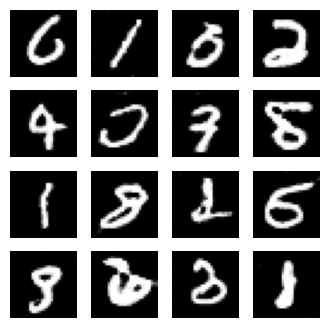

In [14]:
test_noise = torch.randn(16, Noise_DIM, device=device)
generate_and_save_images(generator, Num_epochs, test_noise)